In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchtext
import numpy as np
import sklearn
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import csv
import skopt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ralphmatzner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [132]:
"""
The load_data function loads the nlp dta from the relevant resource. 
Returns: 
    list: A list of strings for further processing is returned.
    list: A list of strings for further processing is returned.
"""
def load_data():
    # https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
    data = []
    with open('./IMDB_Dataset.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='\"')
        for review in reader:
            data.append(review[0:-1])
        
        # To allow for model checking and hyper parameter tuning the dataset 
        # has been abbridged as there is not enough time to train it properly on 25000 samples.
        # Comment out to train on full dataset.
        data = data[0:10]
        data_test = data[10:20]
        
        # Uncomment for full dataset.
        #data = [0:25000]
        #data_test = data[25000:]
        
    return data, data_test
    
"""
The preprocess_data method applies the following preprocessing steps to the data, tokenization.
Params:
    data (list): The data is given as a list of strings to be further processed.
Returns:
    list: A list of preprocessed strings is returned.
"""
def preprocess_data(data):
    pp_words = []
    for text in data:
        tokens = word_tokenize(text[0])
        pp_words.append(tokens)
    return pp_words
    
"""
The embed_data method embeds the words into a n^k plain.
Params:
    data (list): A list of strings that have been tokenized.
    context_size (int): The contexts size of the window.  
Returns:
    dict: The word embedings.
    list of sets: The ngrams.
"""
def embed_data(data, context_size, embedded_dict):
    word_embed = embedded_dict
    ngrams = []
    for text in data:
        vocab = set(text)
        words = {word: i for i, word in enumerate(vocab)}
        z = {**words, **word_embed}
        word_embed = z
    
        for i in range(len(text) - context_size):
            tup = [text[j] for j in np.arange(i , i + context_size) ]
            ngrams.append((tup, text[i + context_size]))
        
    return word_embed, ngrams

In [133]:
"""
The Word2Vec class defines a word2vec model with dimensions and structure as follows.
The structure is an embedding layer, followed by a linear layer with ReLU activation function and
an output layer which is a linear layer with softmax activation function. The dimensions are 
n_words in and embedding dim out, followed by context_size*embed_dim in and 128 out and 128 in 
and n_words out.
"""
class Word2Vec(nn.Module):
    """
    The init function generates the initial state of the model and takes the following parameters.
    Parameters:
        n_words (int): The number of words in the vocab dictionary.
        embed_dim (int): The embedding dimension as an int.
        context_size (int): The context window size as an int.
    """
    def __init__(self, n_words, embed_dim, context_size):
        super(Word2Vec, self).__init__()
        self.n_words = n_words
        self.embed_dim = embed_dim
        self.context_size = context_size
        
        self.embeddings = nn.Embedding(n_words, embed_dim)
        self.linear1 = nn.Linear(context_size*embed_dim, 128)
        self.linear2 = nn.Linear(128, n_words)
       
    """
    The forward function performs a forward pass on the model with the relevant piece of text.
    Parameters:
        sentence (set of ngrams and word pairings): A set of ngrams and word pairings or a single 
        ngram and word pairing.
    Returns:
        list: Returns the model output for the given pieve or text (set of ngrams).
    """
    def forward(self, sentence):
        embeds = self.embeddings(sentence).view((1, -1))  
        out1 = F.relu(self.linear1(embeds))
        out2 = self.linear2(out1)
        softmax = F.log_softmax(out2, dim=1)
        
        return softmax
        
    """
    The predict function takes an ngram and predicts the output of the model for that ngram.
    Predict only works for single inputs.
    Parameters:
        sentence (set of ngrams and word pairings): A set of ngrams and word pairings or a single 
        ngram and word pairing.
        word_window (dict): A dictionary containing all words mapped to a unique int.
    Returns:
        list: Returns the model output for the given pieve or text (set of ngrams).
    """
    def predict(self, sentence, word_window):
        #print(sentence[0])
        context_vecs = torch.tensor([word_window[word] for word in sentence], dtype=torch.long)
        out = model(context_vecs)
        return out
    
    """
    The graph function takes losses and epochs and generates a graph of the loss as it decreases over time.
    Parameters:
        losses (list): The given losses.
        epochs (int): The number of epochs.
    """
    def graph(self, losses, epochs):
        y_val = []
        [y_val.append(epoch) for epoch in range(0,epochs,1)]
        plt.plot(y_val, losses)
        plt.show()
    
    """
    The train function takes ngrams and an embed_dict and trains the model parameters for n epochs.
    Params:
        ngrams (list of sets): A list of sets of ngram and the associated word.
        embed_dict (dict): A dict of words in the vocab.
        epochs (int): An int describing the number of epochs to be used.
    """
    def train(self, ngrams, embed_dict, epochs):
        print('Started training.')
        # Train model.
        losses = []
        loss_function = nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        for epoch in range(0,epochs,1):
            total_loss = 0
            
            for context, target in ngrams:# necessary to expand outside train to pass in as data.
                
                # Prepare inputs for model.
                context_vecs = torch.tensor([embed_dict[word] for word in context], dtype=torch.long)
                
                # Zero gradients.
                model.zero_grad()
                
                # Run forward pass to get log probabilities.
                softmax = model(context_vecs)
                
                # Compute loss.
                loss = loss_function(softmax, torch.tensor([embed_dict[target]], dtype=torch.long))
                
                # Run the backward pass and update the gradients.
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            print('Epoch ' + str(epoch) + ' complete.')
            losses.append(total_loss)
        
        self.graph(losses, epochs)
        print('Ended training.')

Data has been preprocessed.
Stage 1 complete.
Stage 2 complete.
12407.501374721527
Stage 3 complete.
Started training.
Epoch 0 complete.
Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.
Epoch 6 complete.
Epoch 7 complete.
Epoch 8 complete.
Epoch 9 complete.
Epoch 10 complete.
Epoch 11 complete.
Epoch 12 complete.
Epoch 13 complete.
Epoch 14 complete.
Epoch 15 complete.
Epoch 16 complete.
Epoch 17 complete.
Epoch 18 complete.
Epoch 19 complete.
Epoch 20 complete.
Epoch 21 complete.
Epoch 22 complete.
Epoch 23 complete.
Epoch 24 complete.
Epoch 25 complete.
Epoch 26 complete.
Epoch 27 complete.
Epoch 28 complete.
Epoch 29 complete.
Epoch 30 complete.
Epoch 31 complete.
Epoch 32 complete.
Epoch 33 complete.
Epoch 34 complete.
Epoch 35 complete.
Epoch 36 complete.
Epoch 37 complete.
Epoch 38 complete.
Epoch 39 complete.
Epoch 40 complete.
Epoch 41 complete.
Epoch 42 complete.
Epoch 43 complete.
Epoch 44 complete.
Epoch 45 complete.
Epoch 46 complete

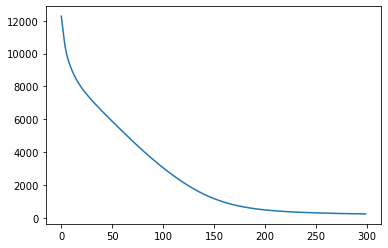

Ended training.
Stage 4 complete.


In [138]:
# Load data and preprocess. In theory Cross validation or
# Bagging should be applied to determin quality of the model 
# and to help with hyperparameter selection. But due to the 
# computational intensity of the dataset and the model and the 
# limited amount of time, these have not been performed.
data, data_test = load_data()
pp_data = preprocess_data(data)
pp_data_test = preprocess_data(data_test)
print('Data has been preprocessed.')

context_size = 3
embed_dict, ngrams = embed_data(pp_data, context_size, {})
embed_dict, ngrams_test = embed_data(pp_data, context_size, embed_dict)
print('Stage 1 complete.')

# Build model and prepare input params.
n_words = len(embed_dict) #check if this is correct.
embed_dim = 10

model = Word2Vec(n_words, embed_dim, context_size)

print('Stage 2 complete.')

# Train model.
#model.train(ngrams, embed_dict, 100)
l = 0
for ng,test in ngrams_test:
    out = model.predict(ng, embed_dict)
    loss = nn.NLLLoss()
    l+= loss(out, torch.tensor([embed_dict[test]], dtype=torch.long)).item()
print(l)
print('Stage 3 complete.')

# Optimize Hyperparameters. The only hyperparameter to think of is 
# lambda for regularisation or the number of epochs. Since we can 
# only optimise the number of epochs hyperparameter selection has not been performed.
ls = []

def optims(ls, model, epochs):
    model.train(ngrams, embed_dict, epochs)
    l = 0
    for ng,test in ngrams_test:
        out = model.predict(ng, embed_dict)
        loss = nn.NLLLoss()
        l+= loss(out, torch.tensor([embed_dict[test]], dtype=torch.long)).item()
        ls.append(l)

# Hyperparameter tuning: 
# Commented out for computation reasons.
#model = Word2Vec(n_words, embed_dim, context_size)
#optims(ls, model, 10)

#model = Word2Vec(n_words, embed_dim, context_size)
#optims(ls, model, 100)

#model = Word2Vec(n_words, embed_dim, context_size)
#optims(ls, model, 200)

#model = Word2Vec(n_words, embed_dim, context_size)
#optims(ls, model, 300)

model = Word2Vec(n_words, embed_dim, context_size)
model.train(ngrams, embed_dict, 300)
torch.save(model.state_dict(), './model')
print('Stage 4 complete.')